### Install Libraries
- OpenCV (opencv-contrib-python)
- Numpy (numpy)
- Matplotlib (matplotlib)

### Utilities

In [46]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def show(title, img, gray=False):
    plt.figure(figsize=(8,6))
    if gray or (img.ndim == 2):
        plt.imshow(img, cmap='gray')
    else:
        # OpenCV uses BGR color order, convert to RGB
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title); plt.axis('off'); plt.show()


### SIFT: Find/match “scale and rotation-tolerant” features
- SIFT finds keypoints that are "robust to scale and rotation."
- Use a float descriptor → Match with L2 distance.
- Use Lowe's ratio test to filter out fake matches (selecting good matches).
- If there are enough matches → Compute the Homography (RANSAC) to project the position boundaries into the scene.

In [47]:
img_t = cv2.imread('../images/object.jpg', cv2.IMREAD_GRAYSCALE)
img_s = cv2.imread('../images/scene.jpg', cv2.IMREAD_GRAYSCALE)
assert img_t is not None and img_s is not None, "Could not open or find the images"

In [48]:
# Initiate SIFT detector
sift = cv2.SIFT_create(
    nfeatures=2000, # The maximum number of features to retain
    contrastThreshold=0.04, # Contrast threshold used to filter out weak features in semi-uniform (low-contrast) regions
    edgeThreshold=10, # Threshold used to filter out edge-like features
    sigma=1.6 # The sigma of the Gaussian applied to the input image at the octave #0
    )
kp_t, des_t = sift.detectAndCompute(img_t, None)
kp_s, des_s = sift.detectAndCompute(img_s, None)

print(f"template keypoints: {len(kp_t)}, scene keypoints: {len(kp_s)}")

template keypoints: 38, scene keypoints: 1477


In [49]:
# Brute-Force (L2) + KNN + Lowe's ratio test

bf = cv2.BFMatcher(cv2.NORM_L2)
knn_matches = bf.knnMatch(des_t, des_s, k=2)

# Apply Lowe's ratio test
good = []
for m, n in knn_matches:
    if m.distance < 0.75 * n.distance:  # ค่ามาตรฐานที่ใช้งานได้ดี
        good.append(m)

print(f"good matches after ratio test: {len(good)}")

good matches after ratio test: 35


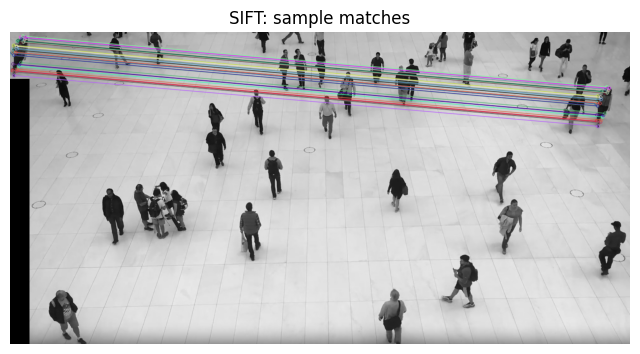

In [50]:
draw_n = min(60, len(good))
match_vis = cv2.drawMatches(img_t, kp_t, img_s, kp_s, good[:draw_n], None,
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show("SIFT: sample matches", match_vis)

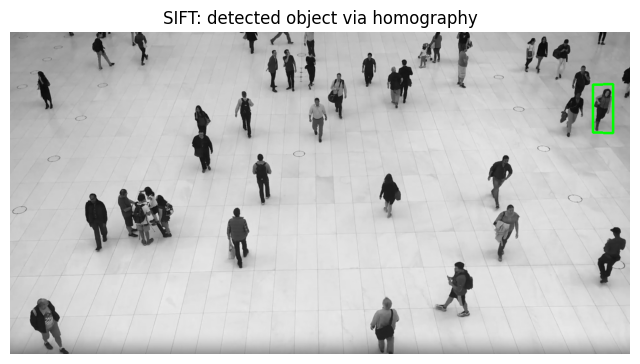

In [51]:
# Homography + RANSAC
if len(good) >= 4:
    src_pts = np.float32([kp_t[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp_s[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if H is not None:
        h, w = img_t.shape
        corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
        proj = cv2.perspectiveTransform(corners, H)

        scene_color = cv2.cvtColor(img_s, cv2.COLOR_GRAY2BGR)
        cv2.polylines(scene_color, [np.int32(proj)], True, (0,255,0), 3)
        show("SIFT: detected object via homography", scene_color)
    else:
        print("Homography not found")
else:
    print("Not enough good matches for homography (must >= 4)")

### ORB — Oriented FAST and Rotated BRIEF
- Match features in real-time/light devices
- ORB = FAST (detector) + BRIEF (descriptor) adapted for rotation
- Descriptor is binary → uses Hamming distance
- Faster and freer than SIFT, but slightly less accurate in some cases

In [52]:
img_t = cv2.imread('../images/object.jpg', cv2.IMREAD_GRAYSCALE)
img_s = cv2.imread('../images/scene.jpg', cv2.IMREAD_GRAYSCALE)
assert img_t is not None and img_s is not None, "Could not open or find the images"

In [53]:
# Initiate ORB detector
orb = cv2.ORB_create(
    nfeatures=5000, # The maximum number of features to retain
    scaleFactor=1.2, # Pyramid decimation ratio
    nlevels=12, # The number of pyramid levels
    edgeThreshold=7, # Size of the border where the features are not detected
    patchSize=21, # Size of the patch used by the oriented BRIEF descriptor
    fastThreshold=5 # FAST threshold for keypoint detection    
)
kp_t, des_t = orb.detectAndCompute(img_t, None)
kp_s, des_s = orb.detectAndCompute(img_s, None)
print(f"template keypoints: {len(kp_t)}, scene keypoints: {len(kp_s)}")

template keypoints: 160, scene keypoints: 5000


In [54]:
# Brute-Force (Hamming) + KNN + Lowe's ratio test

bf = cv2.BFMatcher(cv2.NORM_HAMMING)
knn_matches = bf.knnMatch(des_t, des_s, k=2)

good = []
for m, n in knn_matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)
print(f"good matches: {len(good)}")

good matches: 13


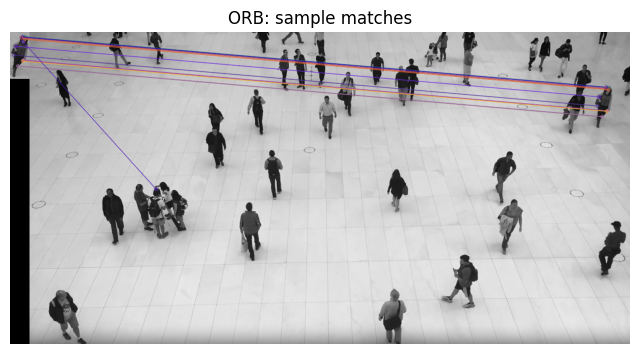

In [55]:
# Draw matches
match_vis = cv2.drawMatches(img_t, kp_t, img_s, kp_s, good[:60], None,
                            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
show("ORB: sample matches", match_vis)

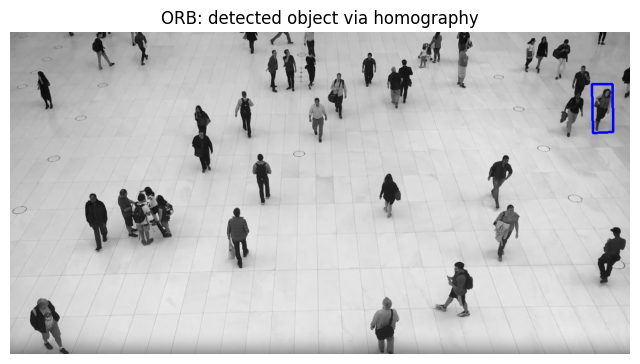

In [56]:
# Homography + RANSAC
if len(good) >= 4:
    src_pts = np.float32([kp_t[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp_s[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if H is not None:
        h, w = img_t.shape
        corners = np.float32([[0,0],[w,0],[w,h],[0,h]]).reshape(-1,1,2)
        proj = cv2.perspectiveTransform(corners, H)

        scene_color = cv2.cvtColor(img_s, cv2.COLOR_GRAY2BGR)
        cv2.polylines(scene_color, [np.int32(proj)], True, (255,0,0), 3)
        show("ORB: detected object via homography", scene_color)

### HOG + SVM Detector (Pedestrian Detection)
- HOG generates a histogram of edge direction in each cell → combines them into a window descriptor.
- Classic formula: HOG + SVM (OpenCV provides model weights).
- Not resistant to large view/layout changes, but fast and easy.

In [ ]:
img = cv2.imread('../images/scene.jpg')
assert img is not None, "Could not open or find the image"

#### Display Simple HOG

In [69]:
img_resized = cv2.resize(img, (64, 128))  # width=64, height=128
hog = cv2.HOGDescriptor()
descriptor = hog.compute(img_resized)

print("HOG feature shape:", descriptor.shape)
print("sample:", descriptor[:10].flatten()) # display first 10 values

HOG feature shape: (3780,)
sample: [0.26449645 0.03782568 0.02109652 0.03605921 0.14250107 0.04261307
 0.0157525  0.04052786 0.28135237 0.13069665]


In [70]:
# HOG visualization
def draw_hog(img, hog, win_size=(64,128)):
    hog_descriptor = cv2.HOGDescriptor(win_size, (16,16), (8,8), (8,8), 9)
    descriptor = hog_descriptor.compute(img)

    n_cells = (img.shape[0] // 8, img.shape[1] // 8)
    cells_per_block = (2, 2)
    orientations = 9
    hog_image = np.zeros((n_cells[0], n_cells[1], orientations))

    descriptor = descriptor.reshape(n_cells[1] - 1, n_cells[0] - 1,
                                    cells_per_block[1], cells_per_block[0], orientations).transpose((1, 0, 2, 3, 4))
    for y in range(n_cells[0] - 1):
        for x in range(n_cells[1] - 1):
            block = descriptor[y, x, :, :, :]
            hog_image[y, x, :] = block.mean(axis=(0,1))

    return hog_image

hog_vis = draw_hog(img_resized, hog)

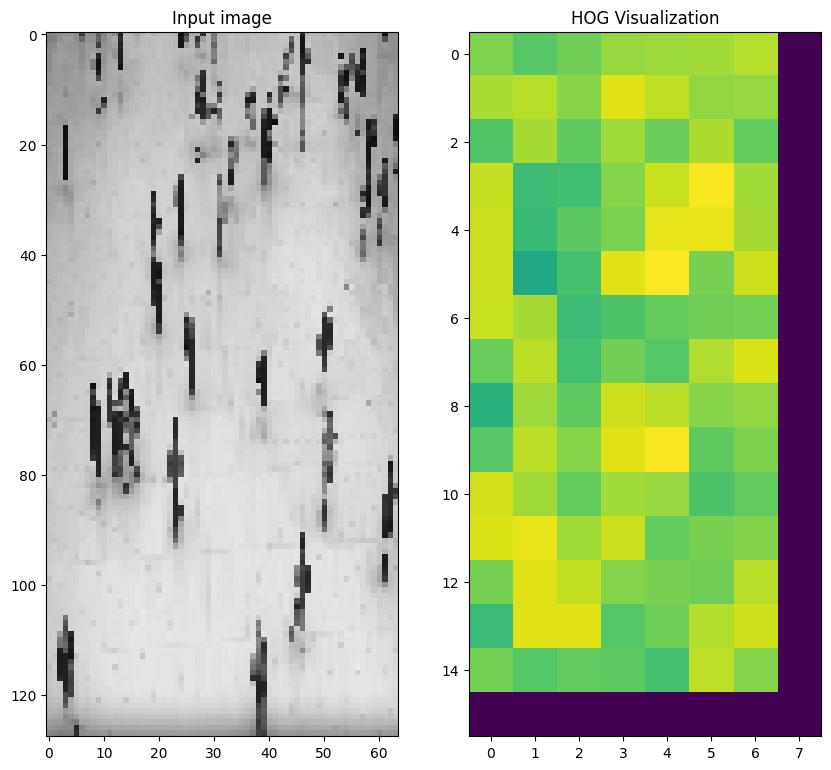

In [77]:
plt.figure(figsize=(10,15))
plt.subplot(1,2,1)
plt.imshow(img_resized, cmap="gray")
plt.title("Input image")

plt.subplot(1,2,2)
plt.imshow(hog_vis.sum(axis=2))
plt.title("HOG Visualization")
plt.show()

#### HOG + SVM Detector

In [59]:
# Initialize HOG + SVM detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

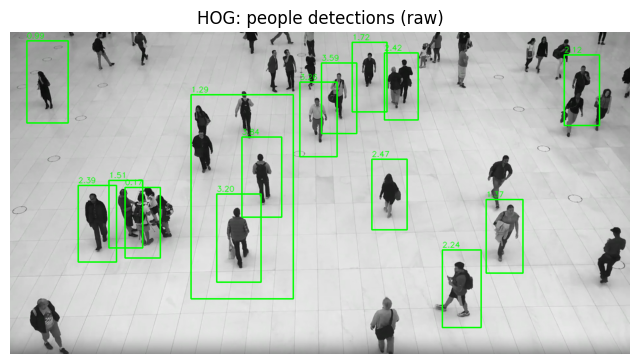

In [62]:
# Detect people
rects, weights = hog.detectMultiScale(
    img,
    winStride=(8,8), # windowing step size (smaller = more detailed but slower)
    padding=(8,8), # padding around the image to avoid missing people at the edges
    scale=1.05 # scaling factor for image pyramid (smaller = more detailed but slower
)

vis = img.copy()
for (x,y,w,h), score in zip(rects, weights):
    cv2.rectangle(vis, (x,y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(vis, f"{score:.2f}", (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

show("HOG: people detections (raw)", vis)

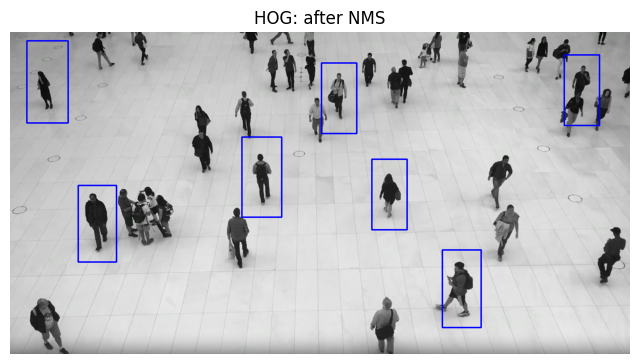

In [64]:
# Non-Maximum Suppression (NMS)
# - Remove overlapping boxes, keep only the one with the highest score

boxes  = [ [x, y, x+w, y+h] for (x,y,w,h) in rects ]
scores = [ float(w) for w in weights ]
indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold=0.5, nms_threshold=0.3)

vis_nms = img.copy()
if len(indices) > 0:
    for i in indices.flatten():
        x1,y1,x2,y2 = boxes[i]
        cv2.rectangle(vis_nms, (x1,y1), (x2,y2), (255,0,0), 2)
show("HOG: after NMS", vis_nms)

### Haar Cascade — Classic Face Detection
- Haar-like features measure "darkness-lightness" on small squares.
- Using a cascade of classifiers (weak → strong), it runs very fast.
- It's not as accurate as deep models, but it's fast and lightweight.

In [127]:
img = cv2.imread('../images/faces.jpg')
assert img is not None, "Could not open or find the image"

In [128]:
# resize for faster processing
img = cv2.resize(img, (0,0), fx=0.1, fy=0.1)

In [129]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [130]:
# Load pre-trained Haar Cascade classifier for face detection
cascade_path = '../haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(cascade_path)
assert not face_cascade.empty(), "Could not load cascade classifier, check the .xml path"

In [131]:
faces = face_cascade.detectMultiScale(
    gray,
    scaleFactor=1.1, # Scale down image by 10% at each step to detect faces at multiple scales
    minNeighbors=5, # Higher value = more "strict", reduces false positives
    minSize=(30,30) # Minimum possible object size
)

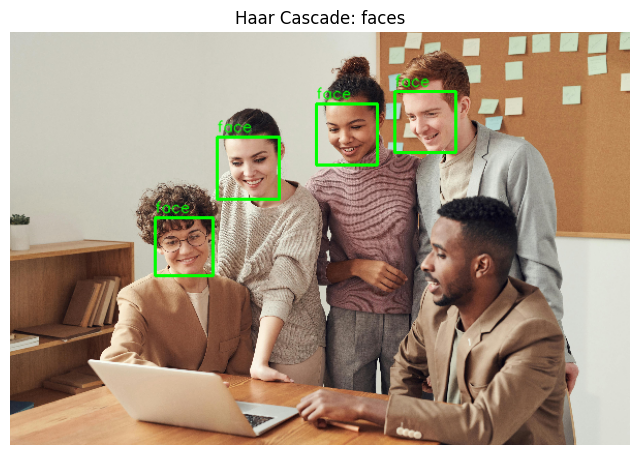

faces detected: 4


In [133]:
vis = img.copy()
for (x,y,w,h) in faces:
    cv2.rectangle(vis, (x,y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(vis, "face", (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)

show("Haar Cascade: faces", vis)
print(f"faces detected: {len(faces)}")